In [ ]:
from __future__ import absolute_import, division, print_function, unicode_literals
import tensorflow as tf

import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import datetime
import os
import PIL
from tensorflow.keras import layers
import time
from google.colab import drive

from IPython import display
import pathlib

tf.__version__

SGDM_clipped, RMS_clipped = 0, 0
SGDM_leaky, RMS_leaky = 0, 0
SGDM_relu, RMS_relu = 0, 0

In [ ]:
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [ ]:
data_dir = pathlib.Path('/content/drive/My Drive/Colab Notebooks/KDEF')
CLASS_NAMES = np.array([item.name for item in data_dir.glob('*') if item.name != "LICENSE.txt"])

def read_images(dataset_path):
    images, labels = np.array([]), list()
    # An ID will be affected to each sub-folders by alphabetical order
    label = 0
    classes = sorted(os.walk(dataset_path).__next__()[1])
    # List each sub-directory (the classes)
    for c in classes:
        c_dir = os.path.join(dataset_path, c)
        walk = os.walk(c_dir).__next__()
        print(c)
        # Add each image to the training set
        for sample in walk[2]:
            # Only keeps jpeg images
            if sample.endswith('.JPG') or sample.endswith('.jpg') or sample.endswith('.jpeg') or sample.endswith('.png'):
                image = tf.io.read_file(os.path.join(c_dir, sample))
                image = tf.image.decode_image(image, channels=3)
                image = tf.image.convert_image_dtype(image, tf.float32)
                image = (image - 0.5) * 2
                image = tf.image.resize(image, size = (60,48))
                image = tf.reshape(image, [1, 60, 48, 3])
                if type(images) == tf.python.framework.ops.EagerTensor:
                  
                  images = np.vstack((images, image))
                else:
                  if images.size != 0:
                    images = np.vstack((images,image))
                  else:
                    images = image
                labels.append(label)
        label += 1
    # Convert to Tensor
    labels
    return images, labels
image, label = 0, 0
image, label = read_images(data_dir)

Angry
Frown
Neutral
Sad
Smile
Surprise


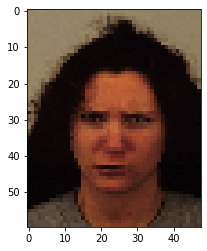

In [ ]:
im = (image[0] *127.5) +127.5
im = im.astype('int32')
plt.imshow(im)
plt.show()

In [ ]:
features_dataset = tf.data.Dataset.from_tensor_slices(image)
labels_dataset = tf.data.Dataset.from_tensor_slices(label)


In [ ]:
# KDEF = np.load('/content/drive/My Drive/Colab Notebooks/tsne_data_RGB_KDEF.npy')
# MMISEL = np.load('/content/drive/My Drive/Colab Notebooks/tsne_data_RGB_MMISEL.npy')
# KDEF_label = np.load('/content/drive/My Drive/Colab Notebooks/tsne_target_RGB_KDEF.npy')
# MMISEL_label = np.load('/content/drive/My Drive/Colab Notebooks/tsne_target_RGB_MMISEL.npy')

# train_images = np.concatenate((KDEF,MMISEL))
# train_labels = np.concatenate((KDEF_label,MMISEL_label))
# print(KDEF.shape, MMISEL.shape, train_images.shape, train_labels.shape)
# train_images = train_images.reshape(train_images.shape[0], 60, 48, 1).astype('float32')
# print(train_images.shape)
# train_images = (train_images - 127.5) / 127.5 # 이미지를 [-1, 1]로 정규화합니다.
print(CLASS_NAMES)
print(len(label))
BUFFER_SIZE = len(label)
BATCH_SIZE = 45
EPOCHS = 50
noise_dim = 128

# # # 데이터 배치를 만들고 섞습니다.
# features_dataset = tf.data.Dataset.from_tensor_slices(train_images)
# labels_dataset = tf.data.Dataset.from_tensor_slices(train_labels)
# print(features_dataset, labels_dataset)
dataset = tf.data.Dataset.zip((features_dataset, labels_dataset))
full_dataset = dataset.shuffle(BUFFER_SIZE)
train_dataset = full_dataset.take(588).batch(BATCH_SIZE)
test_dataset = full_dataset.skip(588)
test_dataset = full_dataset.take(251).batch(251)


['Frown' 'Sad' 'Angry' 'Surprise' 'Smile' 'Neutral']
839


In [ ]:
# def show_batch(image_batch, label_batch):
#   plt.figure(figsize=(10,10))
#   for n in range(25):
#       ax = plt.subplot(5,5,n+1)
#       plt.imshow(image_batch[n])
#       plt.title(CLASS_NAMES[label_batch[n]==1][0].title())
#       plt.axis('off')

# image_batch, label_batch = next(train_images)
# print(image_batch.shape)
relu, leaky, clipped =0,0,0

In [ ]:
def make_generator_model():
  model = tf.keras.Sequential()
  model.add(layers.Dense(15*12*192, use_bias = False, input_shape=(noise_dim,)))
  model.add(layers.BatchNormalization())
  model.add(layers.LeakyReLU())

  model.add(layers.Reshape((15, 12, 192)))

  model.add(layers.UpSampling2D(size = (2, 2)))

  model.add(layers.Conv2D(96, (5, 5), strides=(1, 1), padding='same', use_bias=False))
  model.add(layers.BatchNormalization())
  model.add(layers.LeakyReLU())

  model.add(layers.Conv2D(96, (5, 5), strides=(1, 1), padding='same', use_bias=False))
  model.add(layers.BatchNormalization())
  model.add(layers.LeakyReLU())

  model.add(layers.UpSampling2D(size = (2, 2)))

  model.add(layers.Conv2D(96, (5, 5), strides=(1, 1), padding='same', use_bias=False))
  model.add(layers.BatchNormalization())
  model.add(layers.LeakyReLU())

  model.add(layers.Conv2D(3, (5, 5), strides=(1, 1), padding='same', use_bias=False, activation = 'tanh'))
  # model.add(layers.BatchNormalization())
  # model.add(layers.LeakyReLU())

  # model.add(layers.Dense(7*7*256, use_bias=False, input_shape=(100,)))
  # model.add(layers.BatchNormalization())
  # model.add(layers.LeakyReLU())

  # model.add(layers.Reshape((7, 7, 256)))
  # assert model.output_shape == (None, 7, 7, 256) # 주목: 배치사이즈로 None이 주어집니다.

  # model.add(layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
  # assert model.output_shape == (None, 7, 7, 128)
  # model.add(layers.BatchNormalization())
  # model.add(layers.LeakyReLU())

  # model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
  # assert model.output_shape == (None, 14, 14, 64)
  # model.add(layers.BatchNormalization())
  # model.add(layers.LeakyReLU())

  # model.add(layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
  # assert model.output_shape == (None, 28, 28, 1)

  return model

In [ ]:
def make_discriminator_leaky():
  model = tf.keras.Sequential()
  model.add(layers.Conv2D(96, (5, 5), padding='same', input_shape=[60, 48, 3]))
  model.add(layers.LeakyReLU())
  model.add(layers.Conv2D(96, (3, 3), strides=(1, 1), padding='same'))
  model.add(layers.LeakyReLU())
  model.add(layers.Conv2D(96, (3, 3), strides=(1, 1), padding='same'))
  model.add(layers.LeakyReLU())
  model.add(layers.MaxPool2D(pool_size=(2, 2), strides= (2, 2), padding='same'))

  model.add(layers.Conv2D(192, (3, 3), strides=(1, 1), padding='same'))
  model.add(layers.LeakyReLU())
  model.add(layers.Conv2D(192, (3, 3), strides=(1, 1), padding='same'))
  model.add(layers.LeakyReLU())
  model.add(layers.Conv2D(192, (3, 3), strides=(1, 1), padding='same'))
  model.add(layers.LeakyReLU())
  model.add(layers.MaxPool2D(pool_size=(3, 3), strides= (2, 2), padding='same'))

  model.add(layers.Conv2D(192, (3, 3), strides=(1, 1), padding='same'))
  model.add(layers.LeakyReLU())
  model.add(layers.Conv2D(192, (1, 1), strides=(1, 1), padding='same'))
  model.add(layers.LeakyReLU())
  model.add(layers.Conv2D(5, (1, 1), strides=(1, 1), padding='same'))
  model.add(layers.LeakyReLU())

  model.add(layers.Flatten())
  # model.add(layers.GlobalAveragePooling2D())

  model.add(layers.Dense(6, activation = 'sigmoid'))
  return model

In [ ]:
def make_discriminator_clipped():
  model = tf.keras.Sequential()
  model.add(layers.Conv2D(96, (5, 5), padding='same', input_shape=[60, 48, 3]))
  model.add(layers.ReLU(max_value=10, negative_slope=1.0, threshold=0.0))
  model.add(layers.Conv2D(96, (3, 3), strides=(1, 1), padding='same'))
  model.add(layers.ReLU(max_value=10, negative_slope=1.0, threshold=0.0))
  model.add(layers.Conv2D(96, (3, 3), strides=(1, 1), padding='same'))
  model.add(layers.ReLU(max_value=10, negative_slope=1.0, threshold=0.0))
  model.add(layers.MaxPool2D(pool_size=(2, 2), strides= (2, 2), padding='same'))

  model.add(layers.Conv2D(192, (3, 3), strides=(1, 1), padding='same'))
  model.add(layers.ReLU(max_value=10, negative_slope=1.0, threshold=0.0))
  model.add(layers.Conv2D(192, (3, 3), strides=(1, 1), padding='same'))
  model.add(layers.ReLU(max_value=10, negative_slope=1.0, threshold=0.0))
  model.add(layers.Conv2D(192, (3, 3), strides=(1, 1), padding='same'))
  model.add(layers.ReLU(max_value=10, negative_slope=1.0, threshold=0.0))
  model.add(layers.MaxPool2D(pool_size=(3, 3), strides= (2, 2), padding='same'))

  model.add(layers.Conv2D(192, (3, 3), strides=(1, 1), padding='same'))
  model.add(layers.ReLU(max_value=10, negative_slope=1.0, threshold=0.0))
  model.add(layers.Conv2D(192, (1, 1), strides=(1, 1), padding='same'))
  model.add(layers.ReLU(max_value=10, negative_slope=1.0, threshold=0.0))
  model.add(layers.Conv2D(5, (1, 1), strides=(1, 1), padding='same'))
  model.add(layers.ReLU(max_value=10, negative_slope=1.0, threshold=0.0))

  model.add(layers.Flatten())
  # model.add(layers.GlobalAveragePooling2D())

  model.add(layers.Dense(6, activation = 'sigmoid'))
  return model

In [ ]:
def make_discriminator_relu():
  model = tf.keras.Sequential()
  model.add(layers.Conv2D(96, (5, 5), padding='same', input_shape=[60, 48, 3]))
  model.add(layers.ReLU())
  model.add(layers.Conv2D(96, (3, 3), strides=(1, 1), padding='same'))
  model.add(layers.ReLU())
  model.add(layers.Conv2D(96, (3, 3), strides=(1, 1), padding='same'))
  model.add(layers.ReLU())
  model.add(layers.MaxPool2D(pool_size=(2, 2), strides= (2, 2), padding='same'))

  model.add(layers.Conv2D(192, (3, 3), strides=(1, 1), padding='same'))
  model.add(layers.ReLU())
  model.add(layers.Conv2D(192, (3, 3), strides=(1, 1), padding='same'))
  model.add(layers.ReLU())
  model.add(layers.Conv2D(192, (3, 3), strides=(1, 1), padding='same'))
  model.add(layers.ReLU())
  model.add(layers.MaxPool2D(pool_size=(3, 3), strides= (2, 2), padding='same'))

  model.add(layers.Conv2D(192, (3, 3), strides=(1, 1), padding='same'))
  model.add(layers.ReLU())
  model.add(layers.Conv2D(192, (1, 1), strides=(1, 1), padding='same'))
  model.add(layers.ReLU())
  model.add(layers.Conv2D(5, (1, 1), strides=(1, 1), padding='same'))
  model.add(layers.ReLU())

  model.add(layers.Flatten())
  # model.add(layers.GlobalAveragePooling2D())

  model.add(layers.Dense(6, activation = 'sigmoid'))
  return model

In [ ]:
def marg_entropy(y):
    y1 = tf.math.reduce_mean(y, axis = 0)
    y2 = tf.math.multiply(y1, tf.math.log(y1 + 1e-6))
    y2 = - tf.math.reduce_sum(y2)
    # y2 = tf.math.multiply(y2, 255.0)
    # y2 = tf.cast(y2, dtype = tf.int32)
    # y2 = tf.math.reduce_sum(y2)
    # y2 = tf.cast(y2, dtype = tf.float32)
    # y2 = tf.math.divide(y2, 255.0)
    return y2

# entropy
def entropy(y):
    y1 = - tf.math.multiply(y, tf.math.log(y+ 1e-6))
    y2 = tf.math.multiply(1.0/BATCH_SIZE, tf.math.reduce_sum(y1))
    # y2 = tf.math.multiply(y2, 255.0)
    # y2 = tf.cast(y2, dtype = tf.int32)
    # y2 = tf.math.reduce_sum(y2)
    # y2 = tf.cast(y2, dtype = tf.float32)
    # y2 = tf.math.divide(y2, 255.0)
    return y2

marg = tf.keras.losses.SparseCategoricalCrossentropy(reduction = 'sum')
ent = tf.keras.losses.SparseCategoricalCrossentropy(reduction = 'sum_over_batch_size')


In [ ]:
def discriminator_loss(real_output, fake_output, label):
    # marginal_loss = marg_entropy(real_output.numpy())
    # real_loss = entropy(real_output.numpy())
    # fake_loss = entropy(fake_output.numpy())
    marginal_loss = marg_entropy(real_output)
    real_loss = entropy(real_output)
    fake_loss = entropy(fake_output)
    ce_loss = marg(label, real_output) #[1,] scalar
    total_loss = marginal_loss - real_loss + fake_loss + ce_loss
    return total_loss

def generator_loss(fake_output):
    marginal_loss = marg_entropy(fake_output)
    fake_loss = entropy(fake_output)
    print(fake_loss)
    total_loss =  - marginal_loss + fake_loss
    # total_loss = total_loss * 100

    # total_loss = tf.cast(total_loss, dtype= tf.int32)
    # total_loss = tf.math.reduce_sum(total_loss) / 100
    # total_loss = tf.cast(total_loss, dtype= tf.float32)
    return total_loss

In [ ]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)#RMSprop(1e-4)#SGD(1e-4, 0.9)#
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)#RMSprop(1e-4)#SGD(1e-4, 0.9)#

generator = make_generator_model()
discriminator = make_discriminator_clipped()#make_discriminator_relu()#make_discriminator_leaky()#
discriminator.summary()

Model: "sequential_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_108 (Conv2D)          (None, 60, 48, 96)        7296      
_________________________________________________________________
re_lu_45 (ReLU)              (None, 60, 48, 96)        0         
_________________________________________________________________
conv2d_109 (Conv2D)          (None, 60, 48, 96)        83040     
_________________________________________________________________
re_lu_46 (ReLU)              (None, 60, 48, 96)        0         
_________________________________________________________________
conv2d_110 (Conv2D)          (None, 60, 48, 96)        83040     
_________________________________________________________________
re_lu_47 (ReLU)              (None, 60, 48, 96)        0         
_________________________________________________________________
max_pooling2d_16 (MaxPooling (None, 30, 24, 96)      

In [ ]:
checkpoint_dir = '/content/drive/My Drive/Colab Notebooks/CatGAN_MMI_ckpt'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

gene_loss = tf.keras.metrics.Mean('train_loss', dtype=tf.float32)
discr_loss = tf.keras.metrics.Mean('train_loss', dtype=tf.float32)


gsum = tf.keras.metrics.Mean(dtype =tf.float32)
dsum = tf.keras.metrics.Sum(dtype =tf.float32) 
train_log_dir = '/content/drive/My Drive/Colab Notebooks/logs/train/'
train_summary_writer = tf.summary.create_file_writer(train_log_dir)

In [ ]:
@tf.function
def train_step(images):
    image, label = images
    print(images)
    noise = tf.random.uniform([BATCH_SIZE, noise_dim], seed = 1)
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)
        real_output = discriminator(image, training=True)
        fake_output = discriminator(generated_images, training=True)
        gen_loss = generator_loss(fake_output) #[6,] -> scalar
        disc_loss = discriminator_loss(real_output, fake_output, label) # [6,] -> scalar
        gene_loss(gen_loss)
        discr_loss(disc_loss)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

In [ ]:
def train(dataset, epochs):
    for epoch in range(epochs):
        start = time.time()
        batch_no = 0
        for batch in dataset:
            train_step(batch)
            batch_no += 1
            if batch_no % 5 == 0:
              print(gene_loss.result().numpy(), discr_loss.result().numpy())
              g_loss.append(gene_loss.result().numpy()) 
              d_loss.append(discr_loss.result().numpy())
        

        # GIF를 위한 이미지를 바로 생성합니다.
        display.clear_output(wait=True)
        generate_and_save_images(generator, epoch + 1)
        with train_summary_writer.as_default():
            tf.summary.scalar('gen_loss', gene_loss.result(), step=epoch) 
            tf.summary.scalar('disc_loss', discr_loss.result(), step=epoch)
        
        # 15 에포크가 지날 때마다 모델을 저장합니다.
        if (epoch + 1) % 15 == 0:
            checkpoint.save(file_prefix = checkpoint_prefix)
    
        # print (' 에포크 {} 에서 걸린 시간은 {} 초 입니다'.format(epoch +1, time.time()-start))
        print('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))
    
        template = 'Epoch {}, gen_loss: {}, disc_loss: {}'
        print(template.format(epoch+1, gene_loss.result(), discr_loss.result()))
        

        # Reset metrics every epoch
        gene_loss.reset_states()
        discr_loss.reset_states()
    # 마지막 에포크가 끝난 후 생성합니다.
    display.clear_output(wait=True)
    generate_and_save_images(generator, epochs)
    checkpoint.save(file_prefix = checkpoint_prefix)
    plt.title('Change in cross-entropy loss during training for MMISEL_GB')
    plt.plot(np.arange(len(g_loss)),g_loss, label = 'generator')
    plt.plot(np.arange(len(d_loss)),d_loss, label = 'discriminator')
    plt.legend()
    plt.savefig('/content/drive/My Drive/Colab Notebooks/Train_graph_MMISEL_GB.png')
    plt.show()



In [ ]:
def generate_and_save_images(model, epoch):
# `training`이 False로 맞춰진 것을 주목하세요.
# 이렇게 하면 (배치정규화를 포함하여) 모든 층들이 추론 모드로 실행됩니다.
    noise = tf.random.uniform([4, noise_dim], seed = 1)
    predictions = model(noise, training=False)

    fig = plt.figure(figsize=(4,4))

    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i+1)
        im = predictions[i, :, :, :] * 127.5 + 127.5
        im = tf.cast(im , dtype=tf.int32)
        plt.imshow(im)
        plt.axis('off')

    # plt.savefig('/content/drive/My Drive/Colab Notebooks/images/MMISEL_GB_at_epoch_{:04d}.png'.format(epoch))
    plt.show()

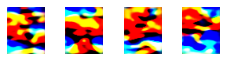

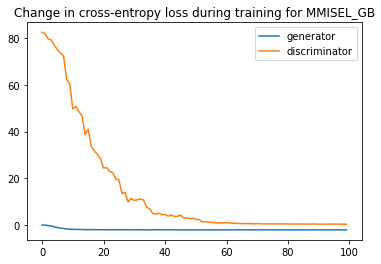

CPU times: user 2min 4s, sys: 40.3 s, total: 2min 44s
Wall time: 6min 22s


In [ ]:
%%time
g_loss =[]
d_loss =[]
train(train_dataset, EPOCHS)

In [ ]:
loss = tf.keras.metrics.Mean('train_loss', dtype=tf.float32)
ms = []

In [ ]:
@tf.function
def test_step(images):
    image, label = images
    noise = tf.random.uniform([BATCH_SIZE, noise_dim], seed = 1)
    generated_images = generator(noise, training=False)
    cat = discriminator(image, training = False)
    print(images, generated_images)
    mse1 = tf.keras.losses.MSE(cat,label)
    mse2 = tf.keras.losses.MSE(generated_images, images)
    loss(mse2)
    



In [ ]:
def test(dataset, epochs):
    sum_mse = 0
    for epoch in range(epochs):
        start = time.time()
        batch_no = 0
        checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))
        i=0
        for image in dataset:
            test_step(image)
            # print(loss.result().numpy())
            ms.append(loss.result().numpy())
        
        # print (' 에포크 {} 에서 걸린 시간은 {} 초 입니다'.format(epoch +1, time.time()-start))
        print('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))
    


    # 마지막 에포크가 끝난 후 생성합니다.
    for i in range(len(ms)):
      sum_mse += ms[i]
    print(sum_mse/len(ms))


In [ ]:
test_im, test_la = next(iter(test_dataset))
print(test_im)
predictions = discriminator.predict(test_im)

tf.Tensor(
[[[[ 1.36070311e-01 -1.21813128e-02 -2.00416595e-01]
   [ 1.29632413e-01 -2.83332728e-02 -2.13259727e-01]
   [ 1.21568680e-01 -3.52940559e-02 -2.30195999e-01]
   ...
   [ 1.60146251e-01  3.28351255e-03 -1.84951767e-01]
   [ 1.29632413e-01 -9.33817495e-03 -1.82990119e-01]
   [ 1.21143691e-01 -4.34650294e-03 -1.91814095e-01]]

  [[ 1.38243541e-01 -2.87499167e-02 -2.19762966e-01]
   [ 1.66666716e-01  1.07843727e-02 -1.77450910e-01]
   [ 1.53725535e-01 -1.09803434e-02 -1.75686210e-01]
   ...
   [ 1.64313778e-01  7.45104533e-03 -1.88627377e-01]
   [ 1.39853001e-01 -1.32346444e-03 -1.73872471e-01]
   [ 1.63855940e-01  1.25490669e-02 -1.73186079e-01]]

  [[ 1.75081760e-01  2.13235896e-02 -1.93872482e-01]
   [ 1.78921610e-01  1.02941766e-02 -1.74019545e-01]
   [ 1.61519676e-01 -2.57346220e-03 -2.05923095e-01]
   ...
   [ 1.67934582e-01  1.38974609e-03 -1.82760239e-01]
   [ 1.46446139e-01 -1.34797953e-03 -1.68995023e-01]
   [ 1.55922964e-01  5.75974397e-03 -1.86274439e-01]]

  ...

 

In [ ]:
def plot_image(i, predictions_array, true_label, img):
  predictions_array, true_label, img = predictions_array[i], true_label[i], img[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])

  plt.imshow(tf.cast(img*127.5 + 127.5, dtype = tf.int32))

  predicted_label = np.argmax(predictions_array)
  if predicted_label == true_label:
    color = 'blue'
  else:
    color = 'red'
  plt.xlabel("{} {:2.0f}% ({})".format(class_names[predicted_label],
                                100*np.max(predictions_array),
                                class_names[true_label]),
                                color=color)

def plot_value_array(i, predictions_array, true_label):
  predictions_array, true_label = predictions_array[i], true_label[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])
  thisplot = plt.bar(range(6), predictions_array, color="#777777")
  plt.ylim([0, 1])
  predicted_label = np.argmax(predictions_array)

  thisplot[predicted_label].set_color('red')
  thisplot[true_label].set_color('blue')

In [ ]:
class_names = ['Angry',
'Frown', 'Neutral',
'Sad',
'Smile',
'Surprise']


print(predictions.shape)
for i in range(predictions.shape[0]):
  predict_label = np.argmax(predictions[i])
  if predict_label == test_la[i]:
    clipped += 1
  else:
    clipped += 0

print(relu/predictions.shape[0])
print(leaky/predictions.shape[0])
print(clipped/predictions.shape[0])

(251, 6)
1.0
0.9681274900398407
1.0


In [ ]:
print(SGDM_relu/predictions.shape[0],SGDM_clipped/predictions.shape[0],SGDM_leaky/predictions.shape[0])

0.7529880478087649 1.0 0.9322709163346613


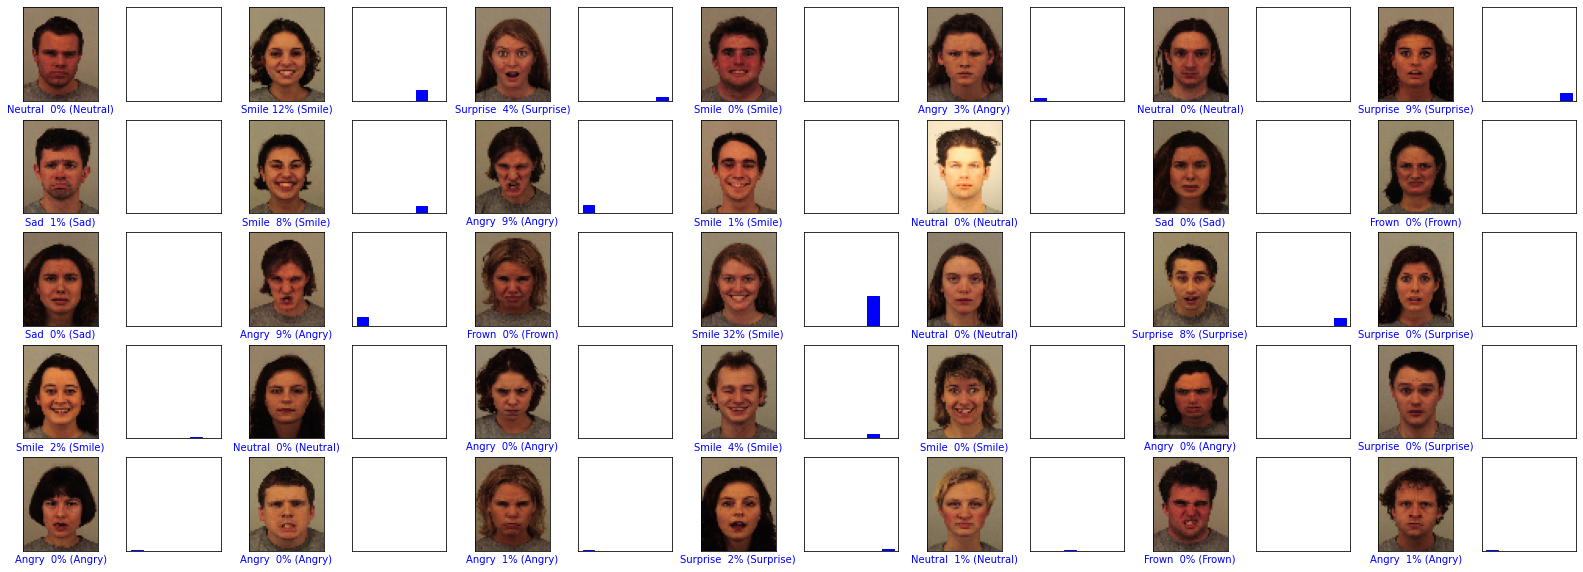

In [ ]:
num_rows = 5
num_cols = 7
num_images = num_rows*num_cols
plt.figure(figsize=(2*2*num_cols, 2*num_rows))
for i in range(num_images):
  plt.subplot(num_rows, 2*num_cols, 2*i+1)
  plot_image(i, predictions, test_la, test_im)
  plt.subplot(num_rows, 2*num_cols, 2*i+2)
  plot_value_array(i, predictions, test_la)
plt.show()

In [ ]:
def gen_image(i, predictions_array, img):
  predictions_array, img = predictions_array[i], img[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])

  plt.imshow(tf.cast(img*127.5 + 127.5, dtype = tf.int32))

  predicted_label = np.argmax(predictions_array)
  plt.xlabel("{}".format(class_names[predicted_label]))

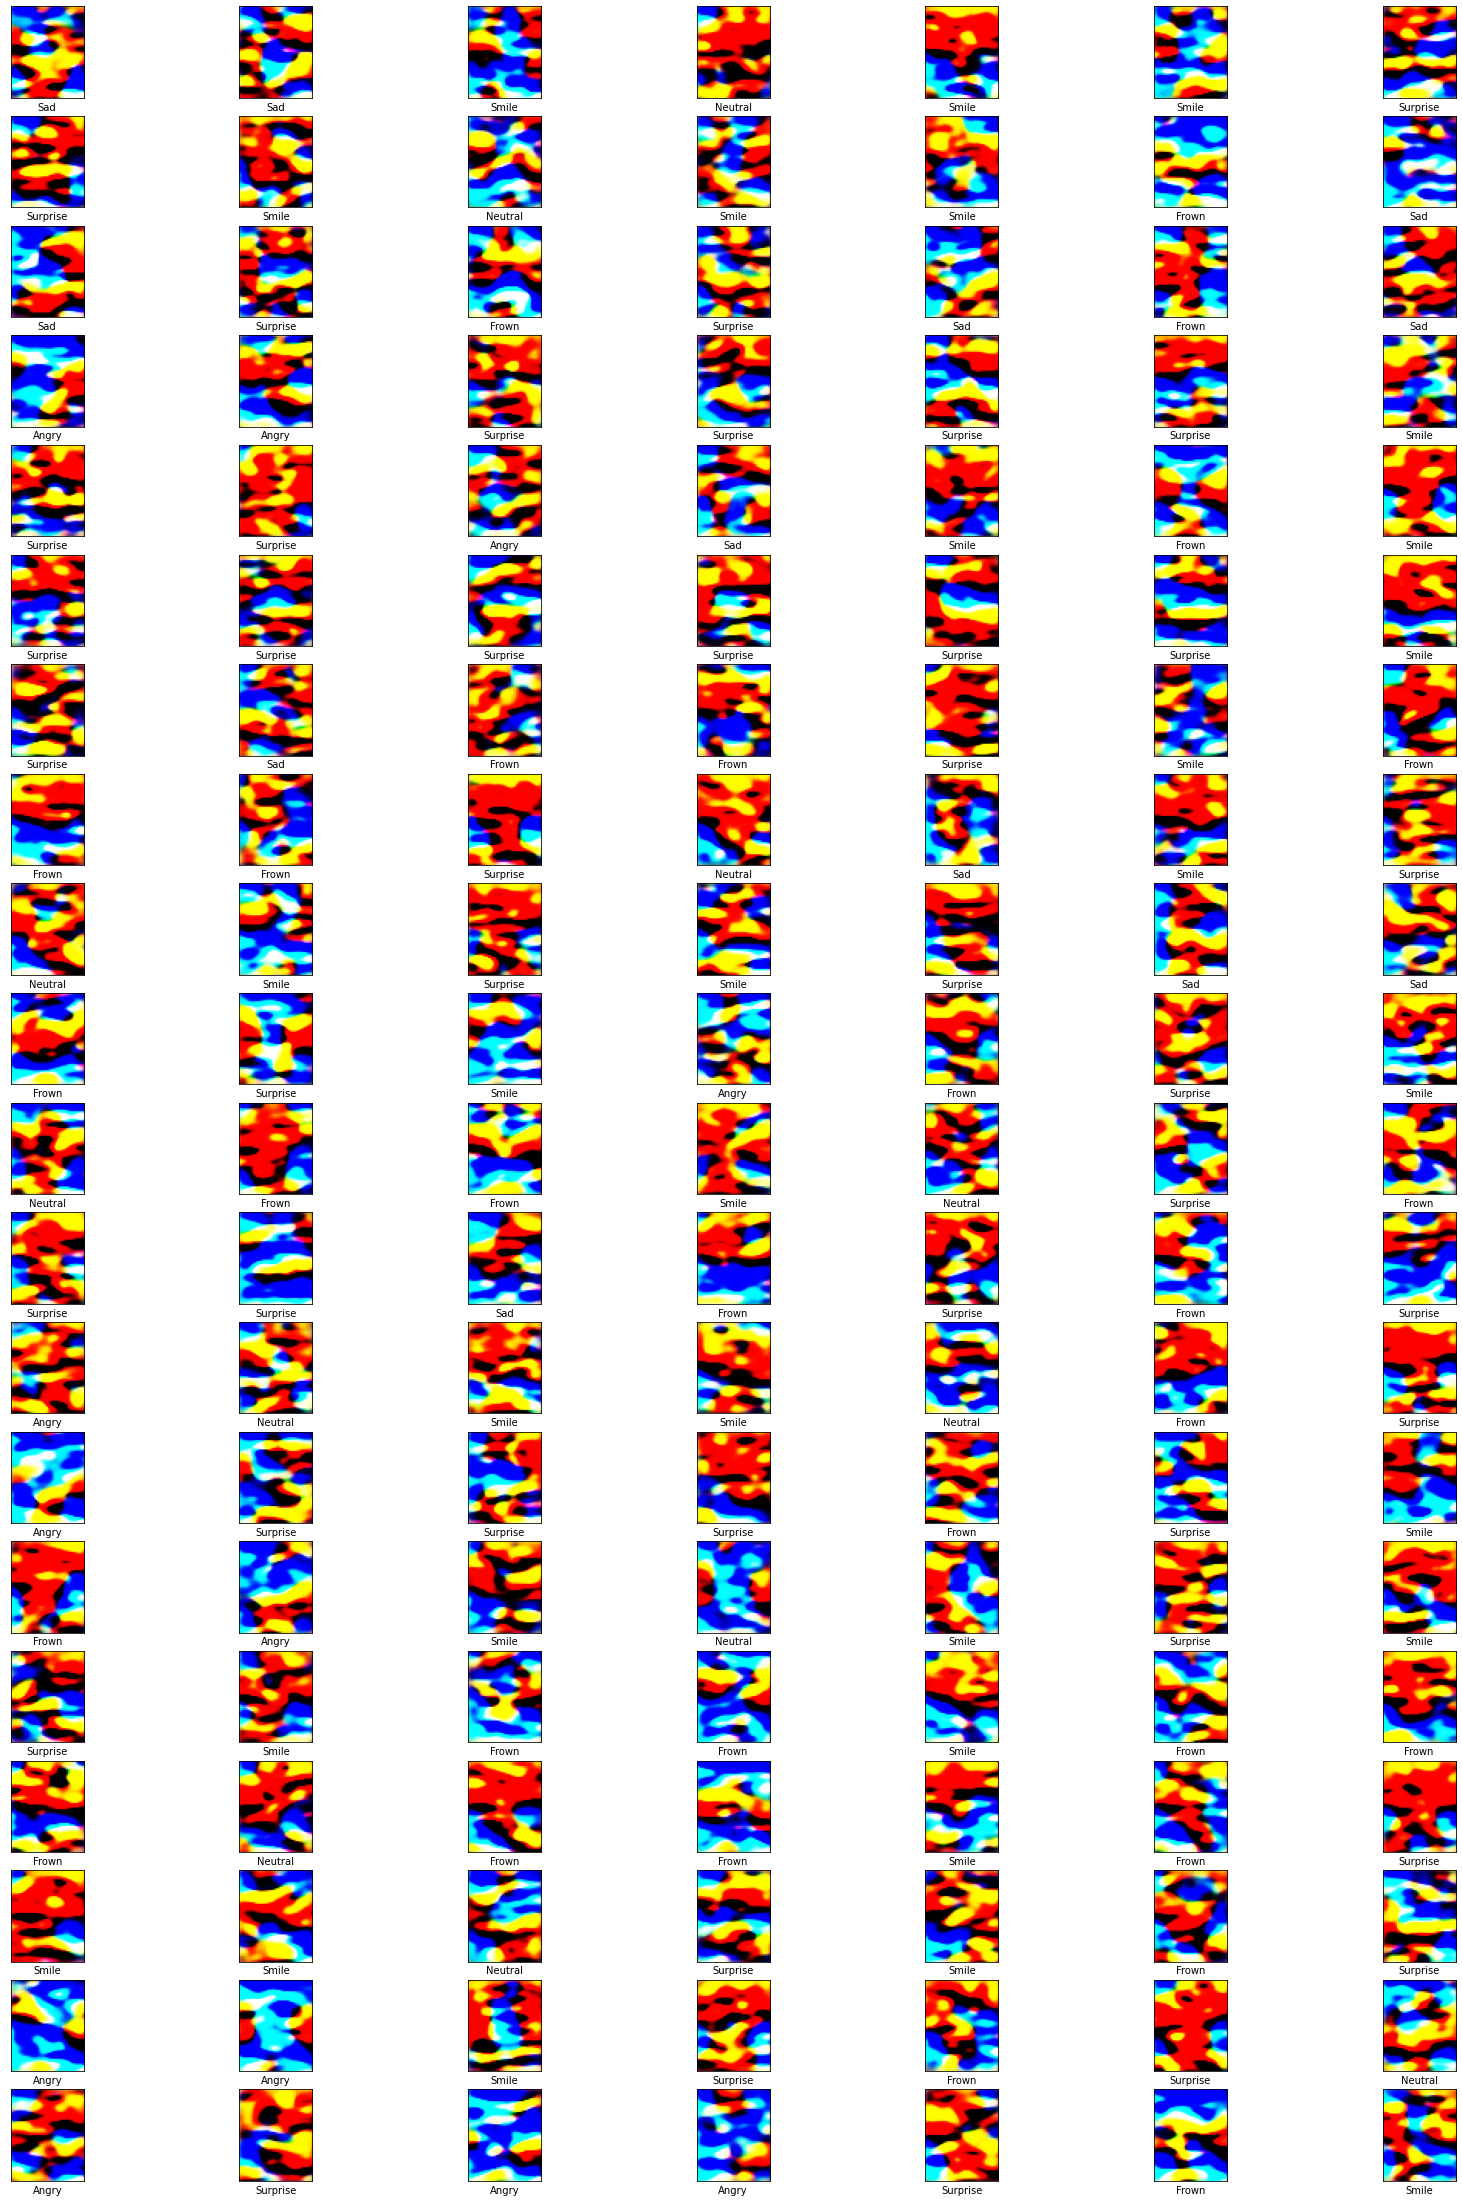

In [ ]:
num_rows = 20
num_cols = 7
num_images = num_rows*num_cols
noise = tf.random.uniform([num_images, noise_dim], seed = 1)
image = generator(noise, training=False)
predicted = discriminator.predict(image)

fig = plt.figure(figsize=(2*2*num_cols, 2*num_rows))

for i in range(image.shape[0]):
    plt.subplot(num_rows, num_cols, i+1)
    gen_image(i, predicted, image)

plt.show()